# Amazon Video Game Data Wrangling

Data from
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [98]:
# import packages
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
%matplotlib inline

# load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')
import string
punctuations = string.punctuation
from  spacy.lang.en.stop_words import STOP_WORDS
# Creating a Spacy Parser
from spacy.lang.en import English
from html import unescape

In [2]:
# initialize spark and koalas
import findspark
findspark.init()
import pyspark
import databricks.koalas as ks

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
# set the app and number of cores to use (work comp 2 cores)
# conf = SparkConf().setMaster('local[2]').setAppName('VideoGamesWrangle') # 2 for BB comp
conf = SparkConf().setMaster('local[4]').setAppName('VideoGamesWrangle') # 4 for my laptop
# set the sparkcontext
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)

In [4]:
vg = pd.read_json('../Amazon_Data/Video_Games_5.json.gz', lines=True, compression='gzip')

In [5]:
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [6]:
vg = vg.loc[:,['overall', 'reviewText']]

## Notes
- 'asin' = product ID
- 'reviewText' = the review text
- 'overall' = the star rating

In [7]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 2 columns):
overall       497577 non-null int64
reviewText    497419 non-null object
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


In [8]:
vg = vg.dropna(how='any')

In [9]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 2 columns):
overall       497419 non-null int64
reviewText    497419 non-null object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


In [10]:
# convert datatype to save memory
vg.loc[:, 'overall'] = vg.overall.astype('int16')

In [11]:
vg.shape

(497419, 2)

In [12]:
vg.overall.value_counts()

5    299623
4     93644
3     49140
1     30879
2     24133
Name: overall, dtype: int64

In [13]:
# create a dataframe from the word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [56]:
# generate and edit stop words
stops = list(STOP_WORDS)
print(stops)

['something', 'perhaps', 'mine', 'among', 'anywhere', 'you', 'over', 'same', 'together', '‘m', 'until', 'eleven', 'themselves', 'be', 'afterwards', 'unless', 'forty', 'mostly', 'off', 'seem', '‘re', 'under', 'yourselves', 'due', 'almost', 'everywhere', 'meanwhile', 'doing', 'either', 'might', 'however', 'top', 'an', 'before', 'during', 'please', 'back', 'one', 'bottom', 'former', 'because', 'moreover', 'thence', 'wherever', 'whoever', '’ve', 'everyone', 'nobody', 'below', 'six', '‘ve', 'will', 'front', 'after', "'ve", 'show', 'but', 'beside', 'quite', 'sixty', 'thereby', 'against', 'not', 'anyone', 'which', 'thru', "'re", 'behind', 'make', 'onto', 'put', 'they', 'hers', 'without', 'she', 'are', 'call', 'besides', '’re', 'serious', 'him', 'two', 'next', 'who', 'hereafter', 'take', 'my', 'ours', 'their', 'or', 'n‘t', 'has', 'should', 'ca', 'more', 'give', 'at', 'beyond', 'become', 'our', 'may', '‘ll', 'again', 'amount', 'nine', 'for', 'had', 'we', '’ll', 'was', 'empty', 'anyhow', 'betwee

In [91]:
stop_words = []
for word in stops:
    if word not in ['not', 'no', 'cannot', 'nothing']:
        stop_words.append(word)
# add additional stopwords
issue_words = ['\ufeff1', '\x16', '...']
for word in issue_words:
    stop_words.append(word)

In [92]:
print(stop_words)

['something', 'perhaps', 'mine', 'among', 'anywhere', 'you', 'over', 'same', 'together', '‘m', 'until', 'eleven', 'themselves', 'be', 'afterwards', 'unless', 'forty', 'mostly', 'off', 'seem', '‘re', 'under', 'yourselves', 'due', 'almost', 'everywhere', 'meanwhile', 'doing', 'either', 'might', 'however', 'top', 'an', 'before', 'during', 'please', 'back', 'one', 'bottom', 'former', 'because', 'moreover', 'thence', 'wherever', 'whoever', '’ve', 'everyone', 'nobody', 'below', 'six', '‘ve', 'will', 'front', 'after', "'ve", 'show', 'but', 'beside', 'quite', 'sixty', 'thereby', 'against', 'anyone', 'which', 'thru', "'re", 'behind', 'make', 'onto', 'put', 'they', 'hers', 'without', 'she', 'are', 'call', 'besides', '’re', 'serious', 'him', 'two', 'next', 'who', 'hereafter', 'take', 'my', 'ours', 'their', 'or', 'n‘t', 'has', 'should', 'ca', 'more', 'give', 'at', 'beyond', 'become', 'our', 'may', '‘ll', 'again', 'amount', 'nine', 'for', 'had', 'we', '’ll', 'was', 'empty', 'anyhow', 'between', 'ca

In [14]:
# remove html entities from docs and
# set everything to lowercase
def my_preprocessor(doc):
    return(unescape(doc).lower())

In [93]:
# define custom tokenizers
parser = English()
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

In [94]:
# get a list of all words each time they occur in the reviews
word_list = []
for text in vg.reviewText:
    for word in my_tokenizer(text):
        word_list.append(word)

In [95]:
# inspect the results
word_list[:20]

['game',
 'bite',
 'hard',
 'hang',
 'great',
 'play',
 'alright',
 'steam',
 'bite',
 'trouble',
 'game',
 'steam',
 'hard',
 'time',
 'activate',
 'play',
 'game',
 'spite',
 'fun',
 'like']

In [96]:
# check for anomalous words that start with a randomly chosen special character
for word in word_list:
    if word.startswith('\\'):
        print(word)

\/+b
\/+b
\"water
\/
\"water
\control
\jameson
\save_game
\save_game
\load_game
\save_game
\the
\/\/ords
\(^u^)/
\/
\/
\now
\have
\my
\\\
\(^0^)/
\|;;|
\and
\|;;|
\and
\program
\.
\much
\.
\m/
\ps3\update
\ps3\savedata
\ps3\export\psv
\m/
\m/(>_<)\m/
\m/\m/
\/.\/
\so
\\=()=//
\m/
\m/
\t/
\[t]/
\best
\_()_/.
\o/
\"water
\\
\(^u^)/


In [99]:
# create regular expression to omit words with special characters
regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')

In [105]:
# edit tokenizer to deal with tokens with special characters
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    mytokens = [word for word in mytokens if(regex.search(word) == None)]
    return mytokens

In [106]:
# get a list of all words each time they occur in the reviews
word_list = []
for text in vg.reviewText:
    for word in my_tokenizer(text):
        word_list.append(word)

In [107]:
# inspect the results
word_list[:20]

['game',
 'bite',
 'hard',
 'hang',
 'great',
 'play',
 'alright',
 'steam',
 'bite',
 'trouble',
 'game',
 'steam',
 'hard',
 'time',
 'activate',
 'play',
 'game',
 'spite',
 'fun',
 'like']

In [109]:
# search for any anomalous words
for word in word_list:
    if regex.search(word) != None:
        print('Found at least one anomalous word: ' + word)
        break
else:
    print('No words fitting regular expression "regex"')

No words fitting regular expression "regex"


In [110]:
# get a count of every word
token_counts = Counter(word_list)

In [111]:
type(token_counts)

collections.Counter

In [114]:
token_counts.most_common(100)

[('game', 1270045),
 ('not', 778419),
 ('play', 392340),
 ('like', 311992),
 ('good', 299622),
 ('time', 210452),
 ('great', 203755),
 ('use', 163200),
 ('fun', 157584),
 ('no', 136833),
 ('little', 119939),
 ('character', 119699),
 ('buy', 119010),
 ('new', 114226),
 ('look', 112645),
 ('2', 111422),
 ('story', 110267),
 ('thing', 108666),
 ('love', 108567),
 ('...', 101638),
 ('work', 100295),
 ('feel', 100137),
 ('find', 97464),
 ('want', 96558),
 ('way', 96516),
 ('level', 93500),
 ('think', 93053),
 ('graphic', 92046),
 ('come', 91447),
 ('lot', 88022),
 ('player', 80702),
 ('3', 78321),
 ('try', 71898),
 ('need', 70107),
 ('know', 68466),
 ('system', 67045),
 ('control', 66399),
 ('gameplay', 66366),
 ('pretty', 66073),
 ('controller', 64820),
 ('people', 64361),
 ('different', 60719),
 ('long', 60512),
 ('easy', 59418),
 ('mode', 59081),
 ('year', 58753),
 ('hard', 57824),
 ('start', 57788),
 ('old', 57693),
 ('enemy', 57349),
 ('sound', 56587),
 ('far', 54907),
 ('hour', 54802)

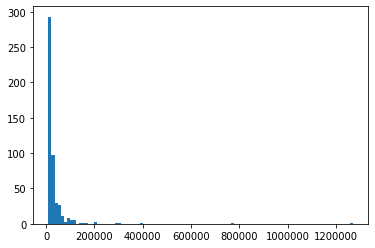

In [125]:
# create histogram of word appearances
# most words occur infrequently, so threshold for num influences this plot greatly
values = []
for tup in token_counts.most_common():
    word, num = tup
    if num > 10000:
        values.append(num)
_ = plt.hist(values, bins=100)

In [126]:
# most words appear very infrequently

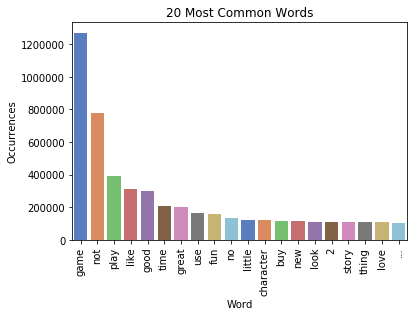

In [135]:
# plot the 20 most common words
words = []
values = []
for tup in token_counts.most_common(20):
    word, num = tup
    words.append(word)
    values.append(num)
_ = sns.barplot(words, values, palette='muted')
_ = plt.xticks(rotation=90)
_ = plt.title('20 Most Common Words')
_ = plt.xlabel('Word')
_ = plt.ylabel('Occurrences')

In [115]:
# character decoding issues?
# seems to be solved using regex
print(my_tokenizer(vg.reviewText[6541]))

['buy', 'age', 'wonders', 'come', 'game', 'opinion', 'computer', 'fantasy', 'war', 'game', 'option', 'different', 'race', 'seven', 'different', 'sphere', 'magic', 'definitely', 'plenty', 'diversity', 'replay', 'value', 'game', 'spell', 'effect', 'charm', 'musical', 'score', 'beautiful', 'single', 'player', 'campaign', 'great', 'story', 'line', 'multi', 'player', 'aspect', 'single', 'scenario', 'good', 'develope', 'heroes', 'customizable', 'choose', 'actually', 'hero', 'represent', 'play', 'field', 'good', 'die', 'lose', 'thing', 'change', 'game', 'unit', 'icon', 'honest', 'artwork', 'icon', 'little', 'lack', 'like', 'rush', 'product', 'gate', 'age', 'wonders', 'awesome', 'game', 'definitely', 'look', 'forward', 'age', 'wonders', '2']


In [17]:
# create vectorizer
vectorizer = CountVectorizer(min_df=0, analyzer='word', decode_error='replace', 
                             preprocessor=my_preprocessor, tokenizer=my_tokenizer)

In [18]:
# fit_transform the data
# vectorizer.fit(vg.reviewText.values)
# X_vec = vectorizer.transform(vg.reviewText.values)
X_vec = vectorizer.fit_transform(vg.reviewText.values)
X_vec = X_vec.tocsc()

In [19]:
# show the number of words in the text 
print('The number of words in the text data is {}'.format(X_vec.shape[1]))

The number of words in the text data is 228890


In [20]:
X_vec.shape

(497419, 228890)

In [21]:
# get the words from the vocabulary
words = np.array(vectorizer.get_feature_names())

In [22]:
len(words)

228890

In [23]:
# need to do a better job cleaning the words first
print(words[1])
print(words[5465])
print(words[54545])
print(words[44599])
print(words[55699])
print(words[77121])
print(words[101010])
print(words[202020])
print(words[222222])

once
-skills
center-40mm
belonging
charizard
duelshock
govez
them.even
wildarms


In [24]:
# create a dataframe from the X array for summary stats
# memory error
#df = ks.DataFrame(X_vec.toarray())

In [25]:
# create a dataframe to hold the number of reviews a word appears in
# num_appear = []
# tot = X_vec.shape[0]
# for i in range(X_vec.shape[1]):
#     num_appear.append(np.sum(X_vec!=0))
#     apps = np.array(num_appear)
#counts_df = pd.DataFrame({'apps': apps})

In [37]:
# what is this dtype??
words.dtype

dtype('<U2625')

In [26]:
# I think this will give me the vector I want (the sum of all columns)
apps = np.sum(X_vec!=0, axis=0)

In [27]:
apps.shape

(1, 228890)

In [28]:
apps[0]

matrix([[    1,     2,     1, ...,     1,     3, 75225]])

In [ ]:
# testing some np functions below

In [181]:
d = np.array([1, 0, 0, 4, 5, 0])

In [ ]:
d!=0

In [106]:
# return the indices for the most common words
# get the total number of appearances of each word
#x = np.eye(X_vec.shape[1])
count_vec=X_vec.sum(axis=0)[0, :]
idxs = np.argsort(count_vec)

In [20]:
# get the total number of appearances of each word
count_vec=X_vec.sum(axis=0)

In [21]:
count_vec.shape

(1, 231626)

In [54]:
for key, value in vectorizer.vocabulary_.items():
    for i in range(count_vec.shape[1]):
        

231626

In [ ]:
# create tfidf vectorizer
tfvectorizer = TfidfVectorizer(tokenizer = my_tokenizer)

In [14]:
# process the text from the tfidf vectorizer
# .vocabulary_ contains the dictionary of indices and words
# get_feature_names() also contains vocabulary
X_tfvec = tfvectorizer.fit_transform(vg.reviewText)
X_tfvec = X_tfvec.tocsc()

In [20]:
# split the data into features and target and train/test split
# X = vg.reviewText.values
y = vg.overall.values
X_train, X_test, y_train, y_test = train_test_split(X_tfvec, y, test_size=0.25, 
                                                    random_state=42, stratify=y)

In [21]:
# upsample the training data
train = pd.DataFrame({'overall': y_train, 'review_vector': X_train})

In [22]:
train.overall.value_counts()

5    224717
4     70233
3     36855
1     23159
2     18100
Name: overall, dtype: int64

In [23]:
# keep all of the indexes with a review of 5
# generate random samples of the other indexes to equal the value counts of 5
train5 = train[train.overall == 5]
train4_idxs = np.random.choice(train[train.overall == 4].index, 225000, replace=True)
train3_idxs = np.random.choice(train[train.overall == 3].index, 225000, replace=True)
train2_idxs = np.random.choice(train[train.overall == 2].index, 225000, replace=True)
train1_idxs = np.random.choice(train[train.overall == 1].index, 225000, replace=True)

In [24]:
train5.overall.value_counts()

5    224717
Name: overall, dtype: int64

In [25]:
# upsample the data
train = pd.concat([train5, train.iloc[train1_idxs,:], train.iloc[train2_idxs,:], 
                   train.iloc[train3_idxs,:], train.iloc[train4_idxs,:]])

In [26]:
train.overall.value_counts()

4    225000
3    225000
2    225000
1    225000
5    224717
Name: overall, dtype: int64

In [36]:
train.head()

,overall,review_vector
1,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
2,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
3,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
4,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
6,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."


In [28]:
train.shape

(1124717, 2)

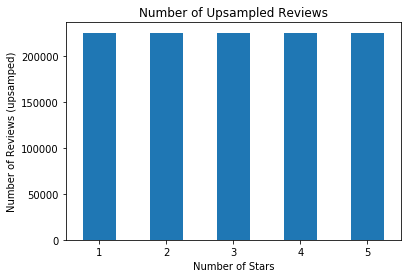

In [29]:
# display plot showing balanced data for training
_ = train.overall.value_counts().sort_index().plot(kind='bar')
_ = plt.title('Number of Upsampled Reviews')
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Reviews (upsamped)')
_ = plt.xticks(rotation=0)

In [30]:
# split training data into X, y
X_train = train.review_vector
y_train = train.overall.values

In [ ]:
# write a function to get the 10 words that occur the most